# Introduction to the problem and our techniques

Credit card frauds are a serious problem. According to the following <a href="https://www.meetup.com/PyDataChi/events/271789356"> source, </a> in 2018, $24.26 Billion was lost due to payment card fraud worldwide. Furthermore, credit fraud is climbing: There is an 18.4 percent increase in 2018. Recent advancements in machine learning and deep learning should help banks make precise decisions. 

That is precisely the purpose of this project. More precisely, we will train several machine learning models to predict credit card frauds from public data that is available at
    
https://www.kaggle.com/mlg-ulb/creditcardfraud

Below is their description of this problem: 

"The datasets contain transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced; the true class (frauds) accounts for only 0.172% of all transactions.

It contains only numerical input variables, which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise."

Unlike typical machine learning classification problems, this particular problem poses a serious challenge: the data is strongly skewed as very few transactions are fraudulent. We will explore several options to deal with this issue. Concretely, we will use the following machine learning models to solve this problem. 

1. Standard and cost-sensitive logistic regression. 


2. Standard and cost-sensitive decision tree classifiers.


3. Standard and cost-sensitive support vector machines. 


These models solve the skewed-data problem by assigning a higher penalty to the positive class. 


We can also over-sample the minority class by a technique called "Synthetic Minority Over-sampling Technique."  We will discuss this method in

4. SMOTE algorithm (Synthetic Minority Over-sampling Technique). 

Finally, we can also use deep learning to detect the minority class by an anomaly-detection algorithm called Autoencoder. 

5. Autoencoder. 

We will compare the performances of these models as well as their trade-offs. 


# Part 1: An overview of the dataset

First, let us import several essential packages. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.core.pylabtools import figsize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import classification_report
import sklearn
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import svm

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

Next, let us import the dataset. 

In [2]:
df =pd.read_csv('creditcard.csv')

A quick snapshot of the dataset

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape

(284807, 31)

Note that this dataset is obtained from PCA, so we expect that most relevant features have 0 mean and are uncorrelated. We can double-check this by using the describe function in python.

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


We can check that the relevant features are uncorrelated as well. We plot the heatmap of the correlations for each pair of features.

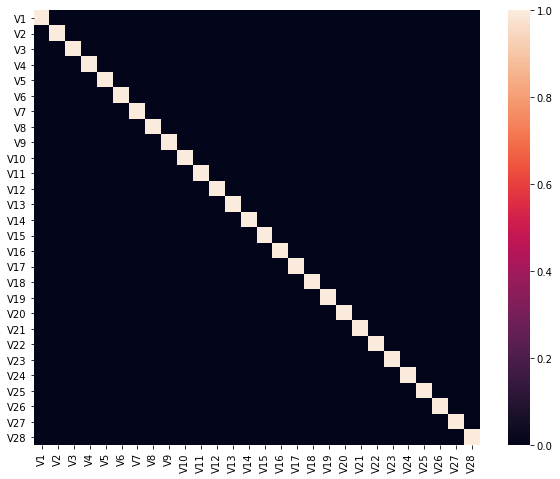

In [6]:
figsize(10, 8)
corr = df.iloc[:, 1:-2].corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns )
plt.show()

Before we build our models, let us investigate the distribution of the target feature. 

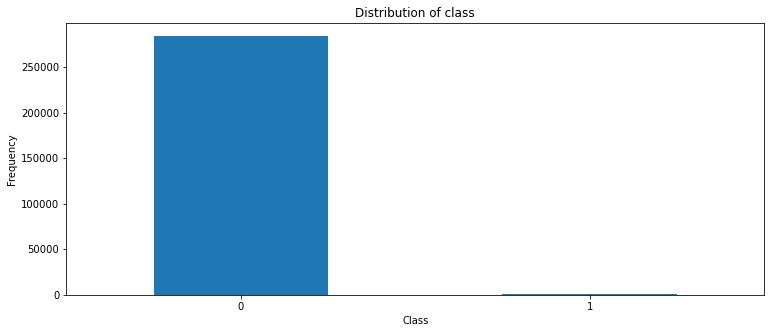

In [7]:
figsize(12.5,5)
df['Class'].value_counts().plot(kind='bar', rot=0)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Distribution of class')
plt.show()

We see clearly that the majority, at least 99.8 %  of transactions, are normal. This skewness in our data will be a big challenge for our models. 

# Part 2: Data visualization

In this part, we get some feelings about the data using data visualization.

First, let us investigate feature V1. 

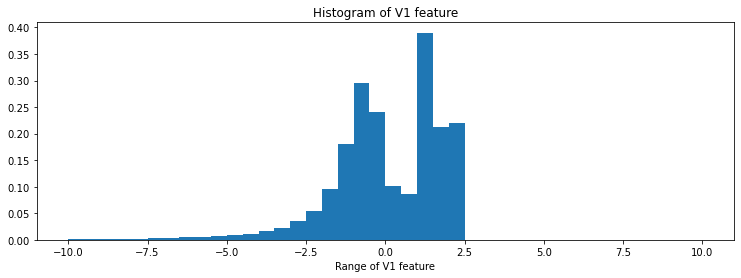

In [8]:
figsize(12.5,4)
plt.xlabel('Range of V1 feature')
plt.title('Histogram of V1 feature')
plt.hist(x=df['V1'], bins=40, range =[-10,10], density=True)
plt.show()

This confirms our previous assertion that the mean should be 0. However, the plot also suggests that feature V1 does
not follow a normal distribution. As we can see, there are two peaks in the above graph.

We can also plot the other features as well. 

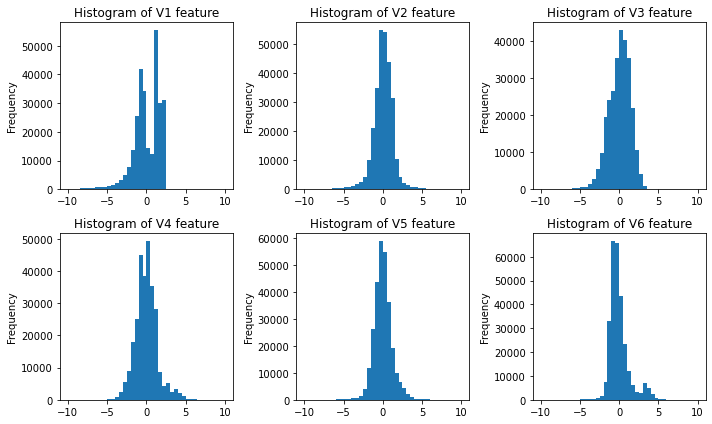

In [9]:
features=['V1', 'V2', 'V3', 'V4', 'V5', 'V6']
fig, axes = plt.subplots(2, 3)
# plot counter
count=0
for r in range(2):
    for c in range(3):
        df[features[count]].plot(kind='hist', ax=axes[r,c], bins =40, title=f"Histogram of {features[count]} feature",
                                figsize=(10,6), range=[-10,10])
        count +=1
        plt.tight_layout()
plt.show()
    

A critical variable in this dataset is the Amount feature. From a business perspective, this is very important. Let us study the distribution of this feature. First, we can compute the mean value for each class (fraud- not fraud)

In [10]:
df.groupby('Class')['Amount'].mean()

Class
0     88.291022
1    122.211321
Name: Amount, dtype: float64

The difference of the means is quite large. Let's investigate more by comparing the for two classes. 

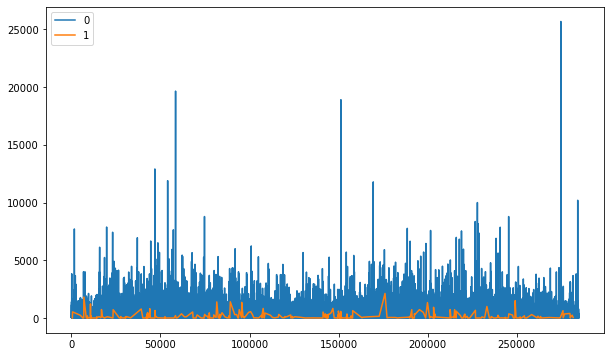

In [11]:
df.groupby('Class')['Amount'].plot(legend=True, figsize=(10,6))
plt.show()

In [12]:
df.groupby('Class')['Amount'].describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,284315.0,88.291022,250.105092,0.0,5.65,22.00,77.05,25691.16
1,492.0,122.211321,256.683288,0.0,1.00,9.25,105.89,2125.87


The above plot and description are rather interesting. The mean and variance of the two classes are quite similar. However, we can see that the amount in fraud transactions are typically smaller than the non-fraud ones. It also makes sense that the maximum value of fraud transactions is just about 2125 euros. This is because a large transaction would probably require authorization from the owner, such as 2-step verification. As a result, fraud could be prevented in most cases. It is still alarming that, on average, it costs 256 euros for each fraud transaction. 

We are also interested in whether the times of transactions play any role in detecting frauds. 

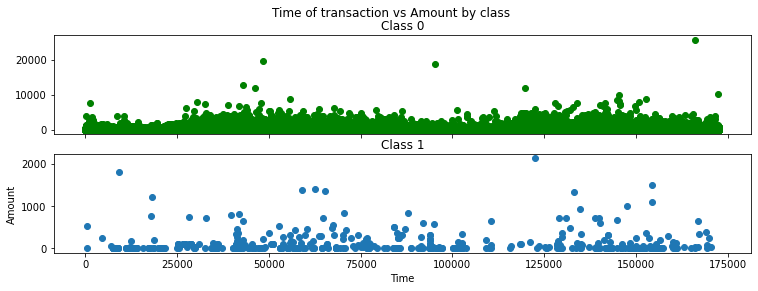

In [13]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(x=df[df['Class']==0]['Time'], y=df[df['Class']==0]['Amount'], label='Class 0', color='green')
ax1.set_title('Class 0')

ax2.scatter(x=df[df['Class']==1]['Time'], y=df[df['Class']==1]['Amount'], label='Class 1')

ax2.set_title('Class 1')

plt.xlabel('Time')
plt.ylabel('Amount')
plt.show()

There does not have any correlation between the amount and time of the transaction. 

# Part 3: Preprocessing our data.

To help our models reach the (local) solutions faster and improve their performances, we will rescale our variables. For our dataset, we only need to rescale the Amount variable (the other variables are obtained from PCA, so we do not need to rescale them.)

In [14]:
from sklearn.preprocessing import StandardScaler

#rescale the amount variable
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))

Next, we divide our data into a training set and a test set. Note that, as we see above, the time variable does not help identify credit card frauds. Consequently, we will not use it in our model. 

In [15]:
#choosing the features for our model 
X=df.drop(['Time', 'Class'], axis=1)
y=df['Class']

#create the train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


Let us check that there are enough samples of fraud class (class 1) in both training and test sets.

In [16]:
#class distribution in the training set
y_train.value_counts()

0    190477
1       343
Name: Class, dtype: int64

In [17]:
#class distribution in the test set
y_test.value_counts()

0    93838
1      149
Name: Class, dtype: int64

We see that there are enough positive samples in both the training set and the test set.

# Part 4: Train and evaluate our models

# Part 4.1: Logistic regression models

We will start with the popular logistic regression algorithm. 



In [18]:
#fit a logistic model to the training set.
model= LogisticRegression(max_iter=10000) 
logit_model=model.fit(X_train, y_train)

Let us visualize the estimation for the parameters in our model.

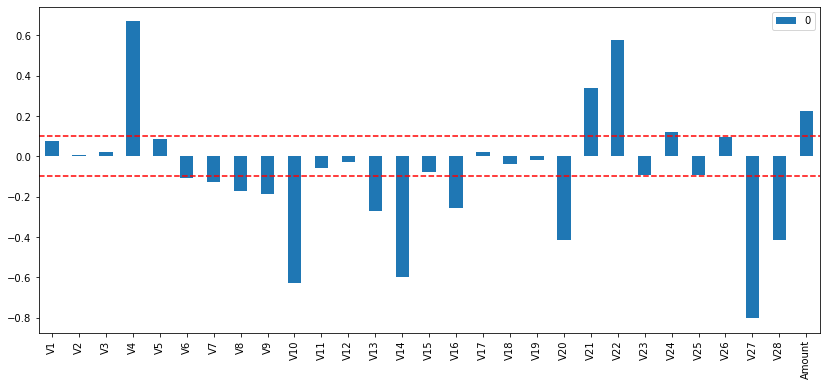

In [19]:
logit_model_coef=[[item] for item in logit_model.coef_[0]]
d=dict(zip(X_train.columns, logit_model_coef))
coef=pd.DataFrame.from_dict(d)
figsize(14,6)
coef.transpose().plot(kind='bar')
plt.axhline(y=0.1, color='r', linestyle='--') 
plt.axhline(y=-0.1, color='r', linestyle='--') 
plt.show()

We see that some of the coefficients are rather small. 

Let's evaluate the performance of our model on the training set and the test set.

In [20]:
#prediction on the training set and the test set
train_prediction = logit_model.predict(X_train)
test_prediction = logit_model.predict(X_test)


We can then compute the confusion matrix as well as the classification report of this model

In [21]:
# Compute the confussion matrix of this model with respect to the training set

sklearn.metrics.confusion_matrix(y_train, train_prediction)

array([[190449,     28],
       [   131,    212]])

In [22]:
print(sklearn.metrics.classification_report(y_train, train_prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    190477
           1       0.88      0.62      0.73       343

    accuracy                           1.00    190820
   macro avg       0.94      0.81      0.86    190820
weighted avg       1.00      1.00      1.00    190820



This model misses about 40% of fraud transactions. Clearly, this result is not satisfying. Let's how it performs on the test set.

In [23]:
# We can also 
print(classification_report(y_test,test_prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93838
           1       0.88      0.63      0.73       149

    accuracy                           1.00     93987
   macro avg       0.94      0.82      0.87     93987
weighted avg       1.00      1.00      1.00     93987



The result does not seem encouraging. We miss 1/3 of the fraud transactions! 


Now, we come to the crucial observation for this problem: we want to catch frauds and consequently, we need to get better recall scores while at the same time control other scores. 

To get a complete picture, we can plot the Precision-Recall curve as well. 

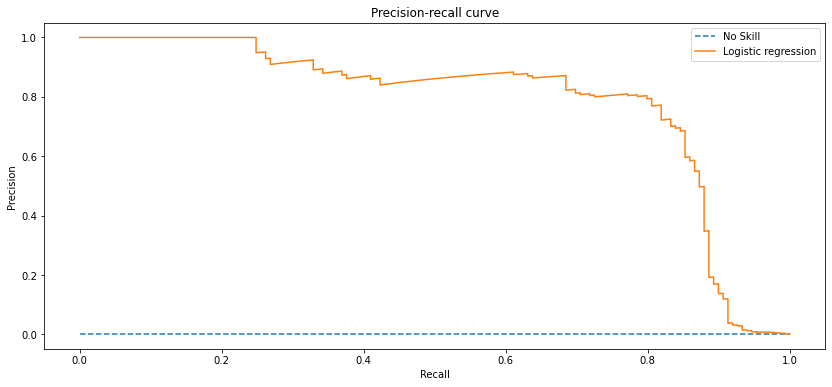

The area under the precision-call curve is 0.785743297444255


In [24]:
from sklearn.metrics import auc
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test==1])*1.0 / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

#get precision and recall from the model
yhat=logit_model.predict_proba(X_test)[:, 1]
precision_1, recall_1, thresholds_1 = precision_recall_curve(y_test, logit_model.predict_proba(X_test)[:, 1])

#plot the precision-recall curve
figsize(12.5,4)
plt.plot(recall_1, precision_1, label='Logistic regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve')
plt.legend()
plt.show()
print(f"The area under the precision-call curve is {sklearn.metrics.auc(recall_1, precision_1)}")

We see this this model does not perform well on both on the training and the test sets. Can we get a better result by using a different set of feature variables?

We write a function that will help us to automatically train our classification models. 

In [25]:
# An automated process for training a logistic regression model
def regression_model(X,y, model):  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    logit_model=model.fit(X_train, y_train)
    train_prediction=logit_model.predict(X_train)
    test_prediction=logit_model.predict(X_test)
    #metrics for the train set
    train_recall = sklearn.metrics.recall_score(y_train, train_prediction)
    train_precision = sklearn.metrics.precision_score(y_train, train_prediction)
    d_train={'Training set precision_score': train_precision, 'Training set recall_score': train_recall}
    
    #metrics for the test set
    test_recall = sklearn.metrics.recall_score(y_test, test_prediction)
    test_precision = sklearn.metrics.precision_score(y_test, test_prediction)
    d_test={'Test set precision_score': test_precision, 'Test set recall_score': test_recall}
    
    #confussion matrix on the training set 
    confusion_matrix_train=sklearn.metrics.confusion_matrix(y_train, train_prediction)
    #confusion matrix on the test set
    confusion_matrix_test=sklearn.metrics.confusion_matrix(y_test, test_prediction)

    #combine the two results 
    d={**d_train, **d_test}
    result=pd.Series(d)
    f, (ax1, ax2) = plt.subplots(1, 2)

    ax1=sns.heatmap(confusion_matrix_train, annot=True, fmt='d', ax=ax1, cmap="Accent") 
    ax1.set_title('Confusion matrix for training set')
    ax1.set_xlabel('Predicted class')
    ax1.set_ylabel('True class')

    sns.heatmap(confusion_matrix_test, annot=True, fmt='d', ax=ax2, cmap='Accent')
    ax2.set_title('Confusion matrix for test set')
    ax2.set_xlabel('Predicted class')
    ax2.set_ylabel('True class')

    plt.show()
    print(result)

Let us apply the above automated process to a different set of feature variables. For example, we could train and test a model without the Amount variable. 

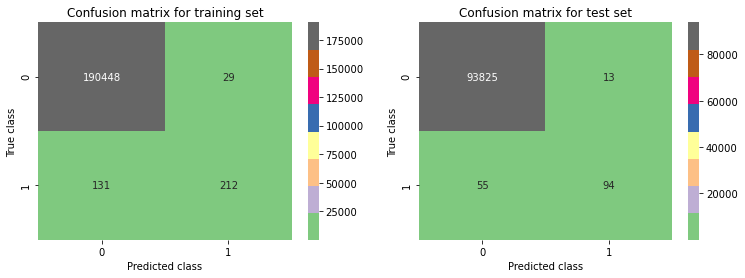

Training set precision_score    0.879668
Training set recall_score       0.618076
Test set precision_score        0.878505
Test set recall_score           0.630872
dtype: float64


In [26]:
X=df.drop(['Time', 'Class', 'Amount'], axis=1)
y=df['Class']
model=LogisticRegression()
regression_model(X,y, model)

We see that the recall-scores are still low. Let us try a different model. 

Note that as our feature variables are already scaled, we can pick the more important features, i.e the ones with bigger coefficients in the first logistic regression model. 
                                                                                                    

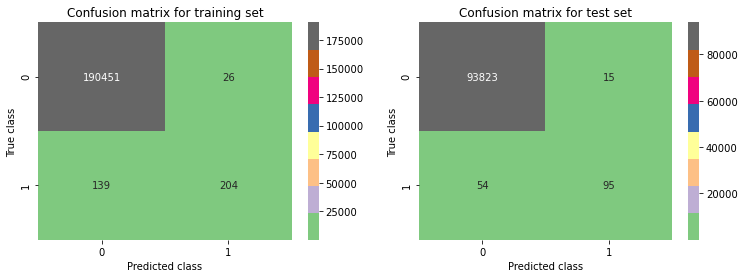

Training set precision_score    0.886957
Training set recall_score       0.594752
Test set precision_score        0.863636
Test set recall_score           0.637584
dtype: float64


In [27]:
X=df[['V4', 'V7', 'V8', 'V10', 'V13', 'V14', 'V16', 'V20', 'V21', 'V22', 'V27', 'V28', 'Amount']]
y=df['Class']
model=LogisticRegression()
regression_model(X,y, model)

We see that the recall score is even lower than the previous one. Let us try another model without the amount variable. 

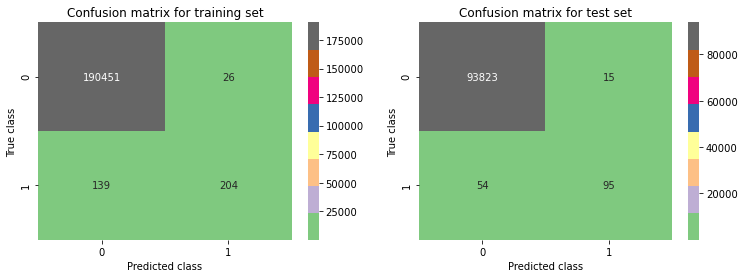

Training set precision_score    0.886957
Training set recall_score       0.594752
Test set precision_score        0.863636
Test set recall_score           0.637584
dtype: float64


In [28]:
X=df[['V4', 'V7', 'V8', 'V10', 'V13', 'V14', 'V16', 'V20', 'V21', 'V22', 'V27', 'V28']]
y=df['Class']
model=LogisticRegression()
regression_model(X,y, model)

We have tried various other combinations, but the recall scores are not encouraging. Our results indicate that we need to either use all features for our models or find alternative ways to select important features. A potential way is to use LASSO regularized logistic regression.

# Part 4.1.2: Regularized logistic regression models.

Our dataset is already normalized so we can use LASSO to fillter out less relevant features. First, we can modify 
the previous code to create automated models. 

In [29]:
from sklearn.linear_model import Lasso

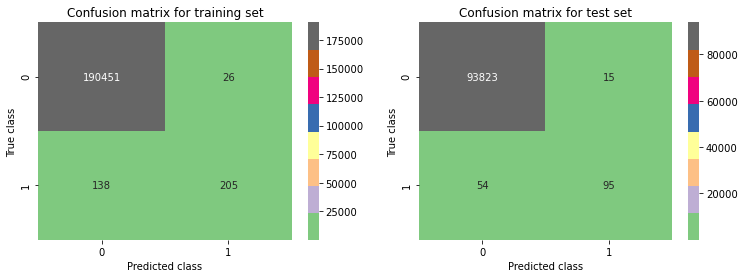

Training set precision_score    0.887446
Training set recall_score       0.597668
Test set precision_score        0.863636
Test set recall_score           0.637584
dtype: float64


In [30]:
#train a regularized logistic regression model
lasso=LogisticRegression(penalty='l1', solver='liblinear', C=10)
lasso_model=regression_model(X, y, lasso)

The performance is still poor. As we mentioned above, one possible way to fix this problem is to select more essential features to train our model. One way to do so is to choose features with large coefficients in the LASSO model.

In [31]:
#get the coefficients of the model
lasso_l1=LogisticRegression(penalty='l1', solver='liblinear', C=10).fit(X_train, y_train)
coefficients=(lasso_l1.coef_).tolist()[0]

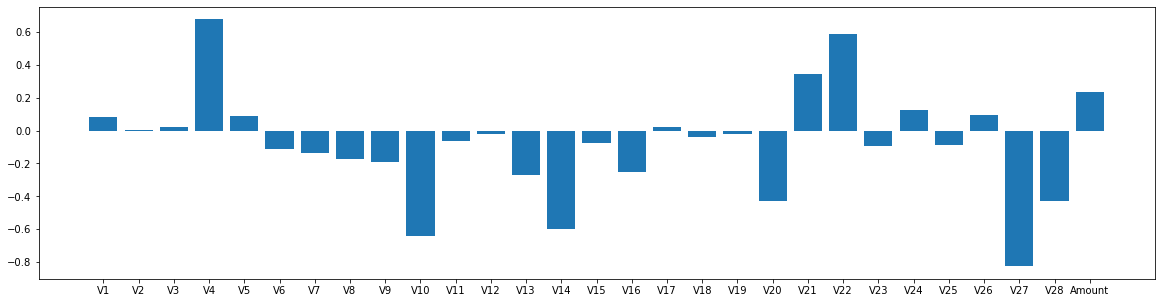

In [33]:
#get the coefficients of the model
coefficients=(lasso_l1.coef_).tolist()[0]
#barplot the coefficients of this model
fig= plt.figure(figsize=(20,5))
plt.bar(range(len(coefficients)), list(coefficients), align='center' )
plt.xticks(range(len(coefficients)), X_train.columns)
plt.show()

Unfortunately, this plot is pretty much similar to the one discussed in the first model. 

We also see that the recall score is still low on both the training and test sets. It seems like this is the best we can do for this problem using "regular" logistic regression. We can argue that the reason for this poor performance is that the data is too skewed. It would be better to have a method which  "harshly" penalizes a misclassification for better recall scores. A potential approach to this problem is to use cost-sensitive logistic regression.

# Part 4.1.3: Cost-Sensitive Logistic Regression

When we train a logistic regression model, we find the set of parameters that minimizes the log-loss function. By definition, the log-function is defined as 
$$ J(x)=-\frac{1}{N} \sum_{i=1}^{N} y_i \ln(p_i)+(1-y_i) \ln(1-p_i),$$
where $y_i \in {0,1}$ is actual class and $p_i$ is the predicted probability of class $1$ ($p_i$ can be written explicitly as a function of the weights together with the logistic function.) The idea is that if our main goal is to avoid missing fraud transactions, then we can put a higher penalty for that mistake. In this subsection, we do some experiments with this idea. First, we use a weight that is often used practice: the weight is inversely propositional to the training set's distribution. 


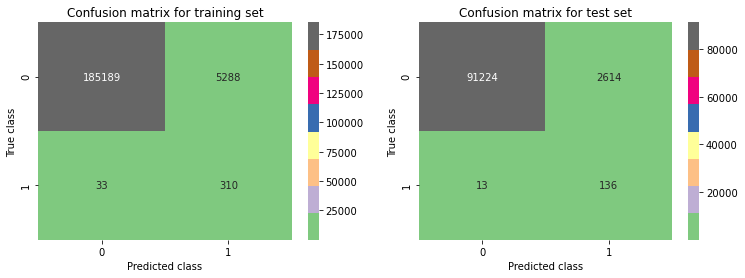

Training set precision_score    0.055377
Training set recall_score       0.903790
Test set precision_score        0.049455
Test set recall_score           0.912752
dtype: float64


In [34]:
#assign the weight for our mdeo
weights={1: 556, 0: 1}

#train a cost sensitive model on the training set
cs_model = LogisticRegression(solver='liblinear', class_weight=weights) #cost senstive model
result=regression_model(X, y, cs_model)

As we can see, this model detect fraud transactions very well (at the cost of misclassing about 5000 non-fraud transactions as fraud).



We observe that this model performs consistently on both the training and test sets. Is it a good model? We believe that there is no universal answer to this question. It should depend on the business context. For example, if we only care about catching credit card frauds, it is clear that this model performs pretty well. However, suppose there are other factors that we concern about, such as whether the false-positive errors will lead to serious customer satisfaction. In that case, we argue that we still have lots of work to do to improve our predictions.  


In this model, we use the recommended weight from the literature. We can also run a GridSearch to find a better better hyperparameter for the weight.

In [35]:
from sklearn.model_selection import GridSearchCV
cost_model = LogisticRegression(solver='liblinear')
weights = [{1:1000,0:1}, {1:500,0:1}, {1:250,0:1}, {1:100,0:1}, {1:10,0:1}]
param_grid = dict(class_weight=weights)
grid = GridSearchCV(estimator=cost_model, param_grid=param_grid, scoring='recall')
grid.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(solver='liblinear'),
             param_grid={'class_weight': [{0: 1, 1: 1000}, {0: 1, 1: 500},
                                          {0: 1, 1: 250}, {0: 1, 1: 100},
                                          {0: 1, 1: 10}]},
             scoring='recall')

In [36]:
print(f" The best score is {grid.best_score_}, and the best weight is  {list((grid.best_params_).values())[0]}")

 The best score is 0.9181585677749361, and the best weight is  {1: 1000, 0: 1}


We will train a new model with the best weight obtained above. 

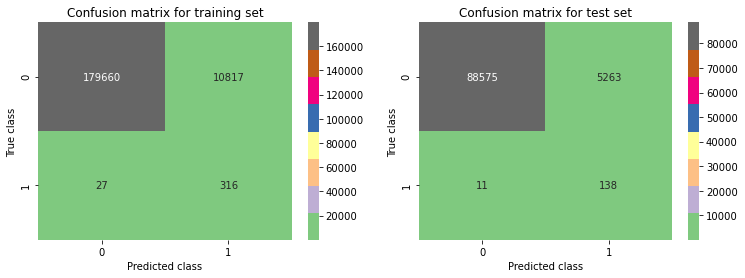

Training set precision_score    0.028384
Training set recall_score       0.921283
Test set precision_score        0.025551
Test set recall_score           0.926174
dtype: float64


In [37]:
#train the model with the weight {0: 1000, 1: 1}
weights={0:1, 1:1000}
cs_model_1 = LogisticRegression(solver='liblinear', class_weight=weights, max_iter=1000) #cost senstive model
result=regression_model(X,y, cs_model_1)

We see that while the recall score improves a little bit, the precision score is significantly dropped. Perhaps, we should stick with the recommended weight 556. 

# Part 4.2: Decision trees

# Part 4.2.1: Standard decision trees

In this section, we are going to use decision tree models for our classification problem. As before, let us do some
experiments with some simpler models before working with the more complicated ones. 

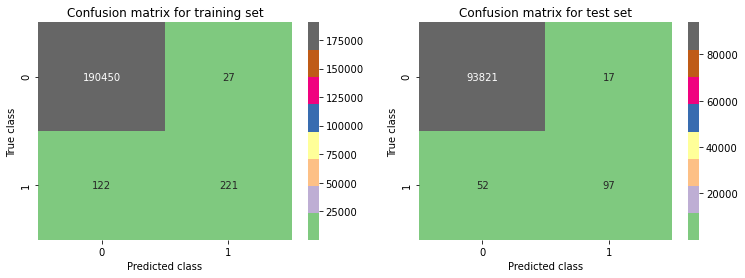

Training set precision_score    0.891129
Training set recall_score       0.644315
Test set precision_score        0.850877
Test set recall_score           0.651007
dtype: float64


In [38]:
#train our first decision tree model with max_depth=3
tree_model = DecisionTreeClassifier(max_depth=3 )
result=regression_model(X,y, tree_model)

As we can see, this model performs better than our previous logistic regression models. However, the recall score is still low. 

In the above model, we choose max_depth=3 as recommended in the literature. We can manually increase
it to see whether the resulting model is better than the old ones. 

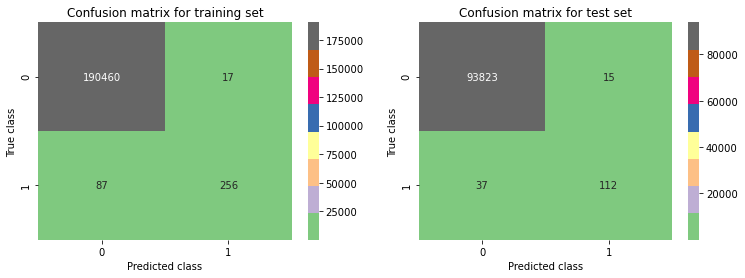

Training set precision_score    0.937729
Training set recall_score       0.746356
Test set precision_score        0.881890
Test set recall_score           0.751678
dtype: float64


In [39]:
#train our first decision tree model with max_depth=4
tree_model = DecisionTreeClassifier(max_depth=4 )
result=regression_model(X,y, tree_model)

We see that this new model with max_depth=4 performs better on both the training set and the test set. Let us take max_length=5.

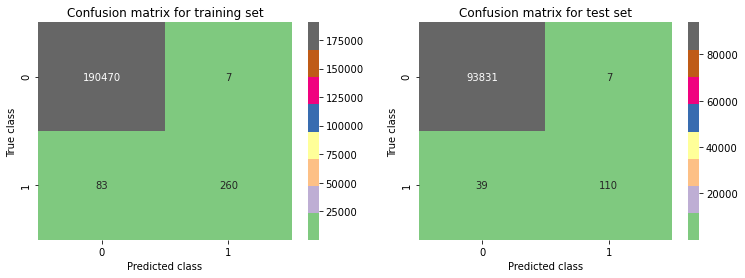

Training set precision_score    0.973783
Training set recall_score       0.758017
Test set precision_score        0.940171
Test set recall_score           0.738255
dtype: float64


In [40]:
#train our first decision tree model with max_depth=5
tree_model = DecisionTreeClassifier(max_depth=5)
result=regression_model(X,y, tree_model)


This is slightly better than the previous ones. Finally, let us take max_depth=6.

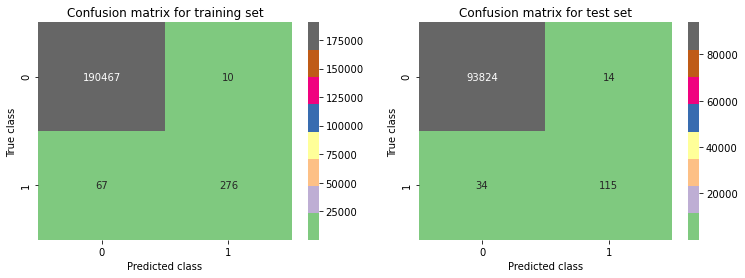

Training set precision_score    0.965035
Training set recall_score       0.804665
Test set precision_score        0.891473
Test set recall_score           0.771812
dtype: float64


In [41]:
#train our first decision tree model with max_depth=5
tree_model = DecisionTreeClassifier(max_depth=6)
result=regression_model(X,y, tree_model)


This performs slightly better on the training set but almost the same on the test set. Let us try one more 
max_depth=7

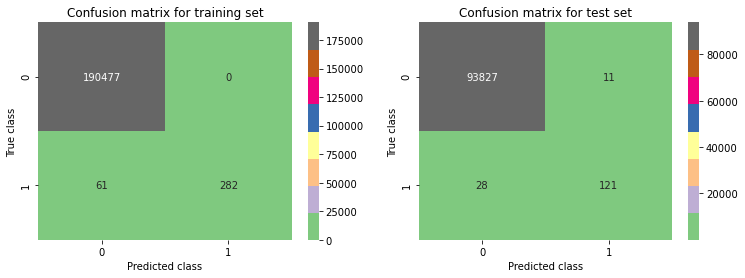

Training set precision_score    1.000000
Training set recall_score       0.822157
Test set precision_score        0.916667
Test set recall_score           0.812081
dtype: float64


In [42]:
#train our first decision tree model with max_depth=7
tree_model = DecisionTreeClassifier(max_depth=7)
result=regression_model(X,y, tree_model)


Overall, it seems that setting max_depth=7 does not improve the old model with max_depth=6 (in fact, we can even argue that doing so would result in overfitting the training set). For this reason, we will take max_depth = 6 for our model.


# Part 4.2.2: Cost-Senstive Decision trees

As discussed in the logistic regression models section, our data is skewed. When we build a decision tree, the decision to split data depends on information gain-which is defined using the Gini index (or other similar measures such as entropy.) Recall that the Gini index is defined as 

$$g= \sum_{i=1}^{K} (p_i-p_i^2)=1-\sum_{i=1}^{K} p_i^2,$$
where $K$ is the number of classes, and $p_i$ is the proportion of class $i$ at a node. If we look into this formula, we see that all classes are considered to be the same. Since our data is skewed, it is better to put higher weights on the minority class. Let us try this idea out. First, let us try the heuristic weight as in logistic regression.


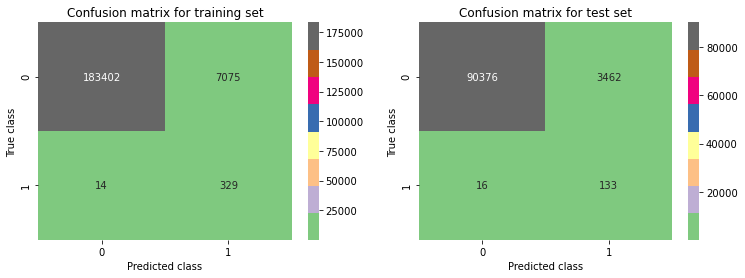

Training set precision_score    0.044435
Training set recall_score       0.959184
Test set precision_score        0.036996
Test set recall_score           0.892617
dtype: float64


In [43]:
#train a tree model for weights = {0:1.0, 1:556.0}
weights={1: 556, 0: 1}
cs_tree_model = DecisionTreeClassifier(max_depth=5, class_weight=weights)
result=regression_model(X,y, cs_tree_model)

The recall scores is pretty good. Unfortunately, the precision score is still rather bad. Let us use another weight. 

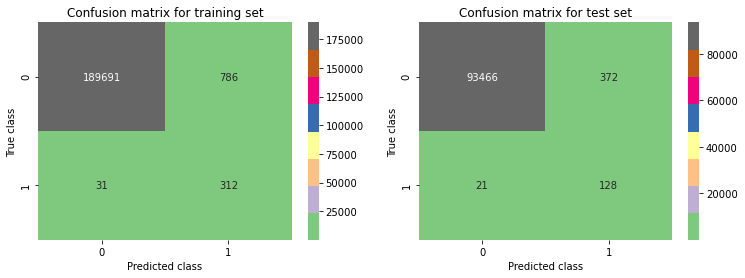

Training set precision_score    0.284153
Training set recall_score       0.909621
Test set precision_score        0.256000
Test set recall_score           0.859060
dtype: float64


In [44]:
#train a tree model for weights = {0:1.0, 1:100.0}
weights={1: 100, 0: 1}
cs_tree_model = DecisionTreeClassifier(max_depth=5, class_weight=weights)
result=regression_model(X,y, cs_tree_model)


We see that while the recall scores are not as good as in the previous model, the false positive errors are significantly reduced. 


We can also do a gridsearch to find a better weight.

In [45]:
#gridsearch on decision tree
from sklearn.model_selection import GridSearchCV
cost_tree_model = DecisionTreeClassifier(max_depth=5)
weights = [{1:1024,0:1}, {1:556,0:1}, {1:250,0:1}, {1:100,0:1}, 
           {1:10,0:1}, {1:1, 0:1}, {1:1, 0:10}, {1:1, 0:100}]
param_tree_grid = dict(class_weight=weights)
tree_grid = GridSearchCV(estimator=cost_tree_model, param_grid=param_tree_grid, scoring='recall')
tree_grid.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(max_depth=5),
             param_grid={'class_weight': [{0: 1, 1: 1024}, {0: 1, 1: 556},
                                          {0: 1, 1: 250}, {0: 1, 1: 100},
                                          {0: 1, 1: 10}, {0: 1, 1: 1},
                                          {0: 10, 1: 1}, {0: 100, 1: 1}]},
             scoring='recall')

In [46]:
print(f"The best weight is  {list((tree_grid.best_params_).values())[0]}")

The best weight is  {1: 1024, 0: 1}


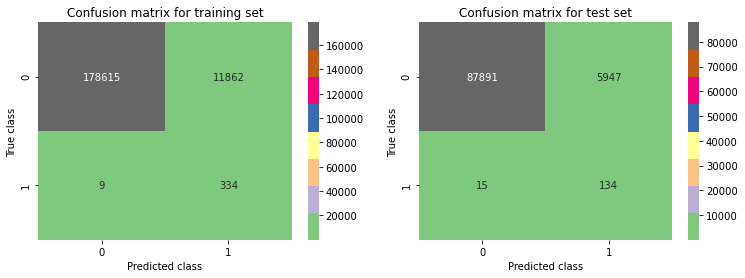

Training set precision_score    0.027386
Training set recall_score       0.973761
Test set precision_score        0.022036
Test set recall_score           0.899329
dtype: float64


In [47]:
#train the model on the new weight {1:1024, 0:1}
weights={1: 1024, 0: 1}
cs_tree_model = DecisionTreeClassifier(max_depth=5, class_weight=weights)
result=regression_model(X,y, cs_tree_model)

This model performance is really good in maximizing recall scores. However, as we can see, its precision scores are poor. 

# Part 4.3: Support vector machine models

Another type of model that we will try is the support vector machine models. 

/Users/hapham/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


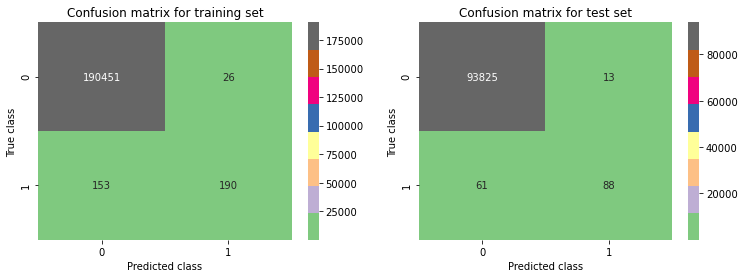

Training set precision_score    0.879630
Training set recall_score       0.553936
Test set precision_score        0.871287
Test set recall_score           0.590604
dtype: float64


In [48]:
#train a support vector machine model
svm_model=svm.LinearSVC(max_iter=5000)
result=regression_model(X,y, svm_model)

We see that the precision scores are too low: we miss a rather big number of fraud transactions. 

As with logistic regression and decision tree models, we can also consider SVC models with weights. We start with the heuristic weights. 

/Users/hapham/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


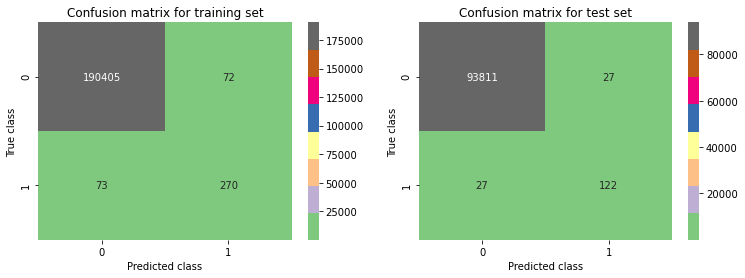

Training set precision_score    0.789474
Training set recall_score       0.787172
Test set precision_score        0.818792
Test set recall_score           0.818792
dtype: float64


In [49]:
#train a SVC model with heuristic weights
weights = {0:1.0, 1:556}
cs_svc_model = svm.LinearSVC(class_weight=weights)
result=regression_model(X,y, cs_svc_model)

We see that the recall score is still rather low. Let us do a Gridsearch CV to find a better parameter for the wight.

In [50]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
cost_svm_model = svm.LinearSVC()
weights = [{1:1024,0:1}, {1:556,0:1}, {1:250,0:1}, 
           {1:100,0:1}, {1:10,0:1}, {1:1, 0:1}, {1:1, 0:10}, {1:1, 0:100}]
param_svm_grid = dict(class_weight=weights)
svm_grid = GridSearchCV(estimator=cost_svm_model, param_grid=param_svm_grid, scoring='recall')
svm_grid.fit(X_train, y_train)

GridSearchCV(estimator=LinearSVC(),
             param_grid={'class_weight': [{0: 1, 1: 1024}, {0: 1, 1: 556},
                                          {0: 1, 1: 250}, {0: 1, 1: 100},
                                          {0: 1, 1: 10}, {0: 1, 1: 1},
                                          {0: 10, 1: 1}, {0: 100, 1: 1}]},
             scoring='recall')

In [ ]:
print(f"The best weight is  {list((svm_grid.best_params_).values())[0]}")

/Users/hapham/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


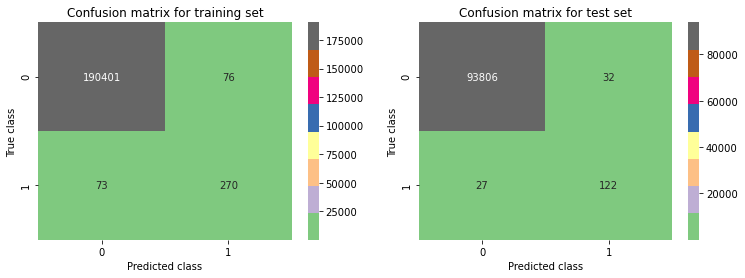

Training set precision_score    0.780347
Training set recall_score       0.787172
Test set precision_score        0.792208
Test set recall_score           0.818792
dtype: float64


In [45]:
weights = {0:1.0, 1:1024}
new_cs_svc_model = svm.LinearSVC(class_weight=weights)
result=regression_model(X,y, new_cs_svc_model)

We see that even with this new weight, the model still performs not so well with respect to the recall score. 

# Part 4.4: The SMOTE (Synthetic Minority Over-sampling Technique) algorithm.

Another possible way to deal with skewed data is to resample the data so that we have balanced classes. For details about this approach, we refer the reader to the following documentation

https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html#smote-adasyn




In [46]:
#resample the training set
from imblearn.over_sampling import SMOTE 
smote = SMOTE(random_state = 2) 
X_train_res, y_train_res = smote.fit_sample(X_train, y_train.ravel()) 


In [47]:
#check that the training set is balanced now
counts_elements = np.unique(y_train_res, return_counts=True)
print(counts_elements)

(array([0, 1]), array([190477, 190477]))


We can then train a logistic regression model on the training set


In [48]:
#train a logistic model with the resampled training set
logit_res=LogisticRegression()
logit_res.fit(X_train_res,y_train_res)

LogisticRegression()

In [49]:
#use the above model to predict
train_prediction_res=logit_res.predict(X_train_res)
test_prediction_res=logit_res.predict(X_test)

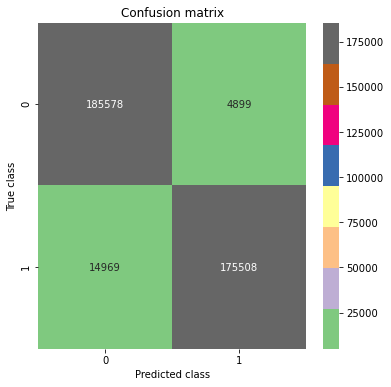

Classification report for the training set:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95    190477
           1       0.97      0.92      0.95    190477

    accuracy                           0.95    380954
   macro avg       0.95      0.95      0.95    380954
weighted avg       0.95      0.95      0.95    380954



In [50]:
#Evaluate this model on the training set 
figsize(6,6)
conf_matrix=sklearn.metrics.confusion_matrix(y_train_res, train_prediction_res)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Accent')
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print("Classification report for the training set:")
print(sklearn.metrics.classification_report(y_train_res, train_prediction_res))

This is pretty good. Let us evaluate this model using the test set. 

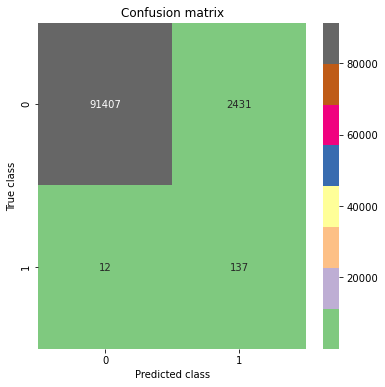

Classification report for the test set:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     93838
           1       0.05      0.92      0.10       149

    accuracy                           0.97     93987
   macro avg       0.53      0.95      0.54     93987
weighted avg       1.00      0.97      0.99     93987



In [51]:
#Evaluate this model on the training set 
figsize(6,6)
conf_matrix=sklearn.metrics.confusion_matrix(y_test, test_prediction_res)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Accent')
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
print("Classification report for the test set:")
print(sklearn.metrics.classification_report(y_test, test_prediction_res))

Argurably, this is the best model so far. 

We can also test the above strategy using a decision tree model.

In [53]:
#smote technique and decision tree
tree_res=DecisionTreeClassifier(max_depth=5)
tree_res.fit(X_train_res,y_train_res)
tree_train_prediction_res=tree_res.predict(X_train_res)
tree_test_prediction_res=tree_res.predict(X_test)

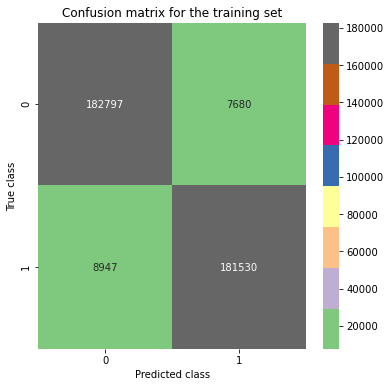

Classification report for the training set:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96    190477
           1       0.96      0.95      0.96    190477

    accuracy                           0.96    380954
   macro avg       0.96      0.96      0.96    380954
weighted avg       0.96      0.96      0.96    380954



In [54]:
#Evaluate this model on the training set 
figsize(6,6)
conf_matrix=sklearn.metrics.confusion_matrix(y_train_res, tree_train_prediction_res)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Accent')
plt.title("Confusion matrix for the training set")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
print("Classification report for the training set:")
print(sklearn.metrics.classification_report(y_train_res, tree_train_prediction_res))

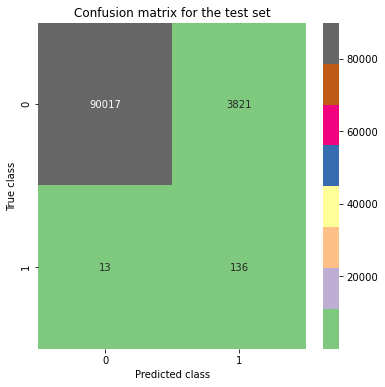

Classification report for the test set:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     93838
           1       0.03      0.91      0.07       149

    accuracy                           0.96     93987
   macro avg       0.52      0.94      0.52     93987
weighted avg       1.00      0.96      0.98     93987



In [56]:
#Evaluate this model on the training set 
figsize(6,6)
conf_matrix=sklearn.metrics.confusion_matrix(y_test, tree_test_prediction_res)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Accent')
plt.title("Confusion matrix for the test set")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
print("Classification report for the test set:")
print(sklearn.metrics.classification_report(y_test, tree_test_prediction_res))

We see that this model performs better than cost-sensitive logistic regression and cost-senstive decision tree. However, it performs worse than the logistic model with SMOTE. 

# Part 4.5: Autoencoders

In the previous sections, we consider our problem as a classification problem. Let us take a different perspective: fraud transactions are abnormal, and therefore, they should have separate "signals." In other words, we can think about our problem as an anomaly detection problem. 

From this perspective, we can use <a href="https://en.wikipedia.org/wiki/Autoencoder#:~:text=An%20autoencoder%20is%20a%20type,to%20ignore%20signal%20%E2%80%9Cnoise%E2%80%9D."> autoencoder </a> to solve our problem. 

Roughly speaking, we will train our model only on normal transactions. Once this is done, our model will learn what is normal and what is fraudulent. Note that our training set and test set are changed in part 4.4, so we load them again. 


In [57]:
X_train, X_test = train_test_split(df, test_size=0.33, random_state=42)

#select normal transactions to train our autoencoder model 
X_train = X_train[X_train['Class'] == 0]
X_train = X_train.drop(['Class', 'Time'], axis=1)

#the test set
y_test = X_test['Class']
X_test = X_test.drop(['Class', 'Time'], axis=1)
X_train = X_train.values
X_test = X_test.values

We need to compute the number of features because this number is the number of nerons in the input layer of our neural network. 

In [58]:
X_train.shape

(190477, 29)

We will build a neural network with number of units 29, 15, 7, 15, 29.  

In [59]:
input_layer = Input(shape=(29, ))
encoder = Dense(15, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(7, activation="relu")(encoder)
decoder = Dense(15, activation='tanh')(encoder)
decoder = Dense(29, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

We then train this autoencoder model with 100 epoches and batch_size=32. 

In [60]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
   1/5953 [..............................] - ETA: 0s - loss: 1.9426 - accuracy: 0.0000e+00WARNING:tensorflow:From /Users/hapham/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
5953/5953 [==============================] - 4s 746us/step - loss: 0.8073 - accuracy: 0.5646 - val_loss: 0.7868 - val_accuracy: 0.6146
Epoch 2/100
5953/5953 [==============================] - 5s 787us/step - loss: 0.7540 - accuracy: 0.6227 - val_loss: 0.7716 - val_accuracy: 0.6316
Epoch 3/100
5953/5953 [==============================] - 5s 765us/step - loss: 0.7432 - accuracy: 0.6323 - val_loss: 0.7651 - val_accuracy: 0.6296
Epoch 4/100
5953/5953 [==============================] - 4s 718us/step - loss: 0.7367 - accuracy: 0.6375 - val_loss: 0.7598 - val_accuracy: 0.6371
Epoch 5/100
5953/5953 [====

In [61]:
autoencoder = load_model('model.h5')

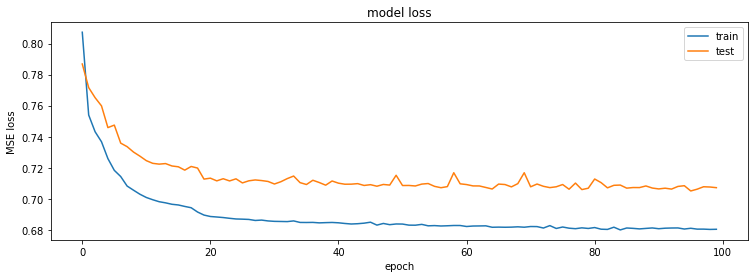

In [62]:
figsize(12.5, 4)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

We see that the reconstruction errors on the training set and the test set do converge. Le us use this model to make predictions. 

In [63]:
#prediction on the test set
predictions = autoencoder.predict(X_test) 

#compute the mean square error on the test set 
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

error = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

#reconstruction error for each class 
error.groupby('true_class').describe()

reconstruction_error                                            \
                          count       mean        std       min       25%   
true_class                                                                  
0                       93838.0   0.653625   2.499995  0.029771  0.225579   
1                         149.0  32.387828  43.926467  0.132721  4.467888   

                                              
                  50%        75%         max  
true_class                                    
0            0.370402   0.600408  218.251768  
1           11.034946  59.887471  268.239157

We see clearly that the fraud transactions' reconstruction errors are much higher than the ones from normal transactions. This suggests that our model has learned to distinguish these two types of transactions. 


What should be the threshold to decide whether a transaction is a fraud or normal one? Let us plot the precision and recall scores for different thresholds. 


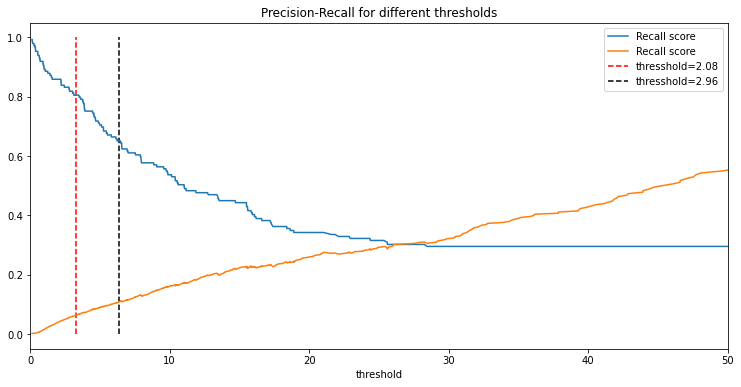

In [64]:
figsize(12.5, 6)
precision, recall, threshold = precision_recall_curve(error['true_class'], error['reconstruction_error'])
plt.plot(threshold, recall[1:], label='Recall score')
plt.plot(threshold, precision[1:], label='Recall score')
plt.vlines(threshold[83000], 0,1, linestyle='--', color='r', label='thresshold=2.08')
plt.vlines(threshold[84000], 0, 1.0, linestyle='--', color='black', label='thresshold=2.96')
plt.xlabel('threshold')
plt.xlim(0,50)
plt.title('Precision-Recall for different thresholds')
plt.legend()
plt.show()

As we can see from this plot, we must use a small threshold to keep our recall score high. As mentioned above, a small threshold would give a low precision score. There is certainly a trade-off here. 

As we can see, there is a trade-off between precision and recall. In our previous models, we already achieved recall scores of at least 90%. Therefore, it is reasonable to expect this new model should at least have that score as well. We first set the threshold to be 2.08.

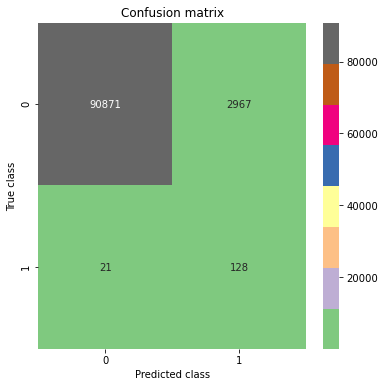

Precision score: 0.04135702746365105
Recall score: 0.8590604026845637


In [65]:
threshold=2.08
y_pred = [1 if e > threshold else 0 for e in error['reconstruction_error'].values]
recall = sklearn.metrics.recall_score(error['true_class'], y_pred)
precision = sklearn.metrics.precision_score(error['true_class'], y_pred)
conf_matrix = sklearn.metrics.confusion_matrix(error['true_class'], y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Accent')
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
print("Precision score:", precision)
print("Recall score:", recall)

Let us try a lower threshold.

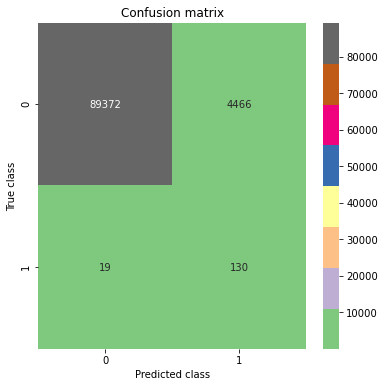

Precision score: 0.028285465622280244
Recall score: 0.87248322147651


In [66]:
threshold=1.5
y_pred = [1 if e > threshold else 0 for e in error['reconstruction_error'].values]
recall = sklearn.metrics.recall_score(error['true_class'], y_pred)
precision = sklearn.metrics.precision_score(error['true_class'], y_pred)
conf_matrix = sklearn.metrics.confusion_matrix(error['true_class'], y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Accent')
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
print("Precision score:", precision)
print("Recall score:", recall)

As we can see, this new threshold does not really improve the recall score. Let us use an even smaller threshold.

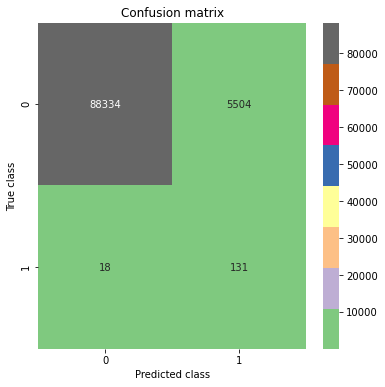

Precision score: 0.023247559893522625
Recall score: 0.8791946308724832


In [67]:
threshold=1.30
y_pred = [1 if e > threshold else 0 for e in error['reconstruction_error'].values]
recall = sklearn.metrics.recall_score(error['true_class'], y_pred)
precision = sklearn.metrics.precision_score(error['true_class'], y_pred)
conf_matrix = sklearn.metrics.confusion_matrix(error['true_class'], y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Accent')
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
print("Precision score:", precision)
print("Recall score:", recall)

This does seem to improve the recall score. However, the precision score is rather low. 

# Part 5: Model comparison

Our results are saved in the excel file "Credit card fraud results". Let us open it to compare the different models that we built above. 

In [106]:
result=pd.read_excel("Credit card fraud results.xlsx")
train=result[result['Dataset']=='train']
test=result[result['Dataset']=='test']
result

,Model,Precision,Recall,Dataset,Remark
0,Logistic regression,0.880,0.62,train,NaN
1,Logistic regression,0.880,0.63,test,NaN
2,LASSO,0.880,0.59,train,NaN
3,LASSO,0.860,0.63,test,NaN
4,Cost-sensitive logistic regression,0.050,0.90,train,weights=556
5,Cost-sensitive logistic regression,0.050,0.91,test,weights=556
6,Decision tree,0.960,0.80,train,max_depth=6
7,Decision tree,0.890,0.79,test,max_depth=6
8,Cost-sensitive decision tree,0.045,0.96,train,weights=556
9,Cost-sensitive decision tree,0.036,0.89,test,weights=556


Let us plot the recall scores on the training set.

<ipython-input-116-881504e0a0b1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.sort_values('Recall', inplace=True, ascending=False)


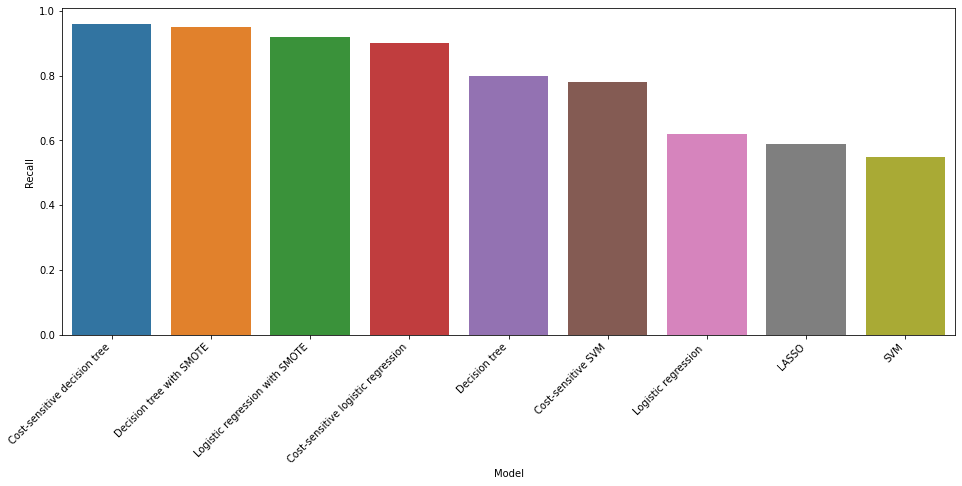

In [116]:
figsize(16, 6)
train.sort_values('Recall', inplace=True, ascending=False)
bar=sns.barplot(x=train['Model'], y=train['Recall'])
bar.set_xticklabels(bar.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

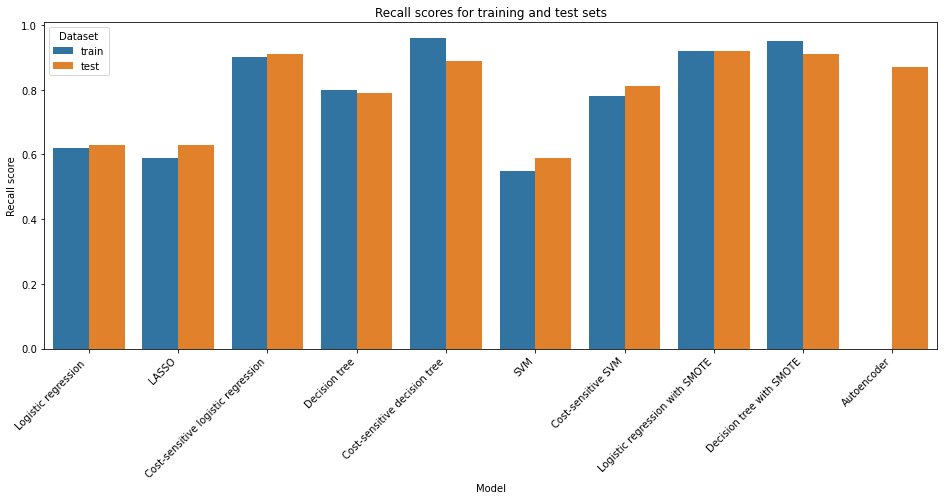

In [119]:
figsize(16, 6)
bar=sns.barplot(result['Model'], y=result['Recall'], hue=result['Dataset'])
bar.set_xticklabels(bar.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Recall scores for training and test sets')
plt.ylabel('Recall score')
plt.show()

As we can  see from this plot, all of our models do not overfit the data: they perform consistently on the training set and the test set. If recall score is the ONLY thing that we care about, then Logistic regression with SMOTE and decision tree with SMOTE models perform the best. 

What about precision scores? 

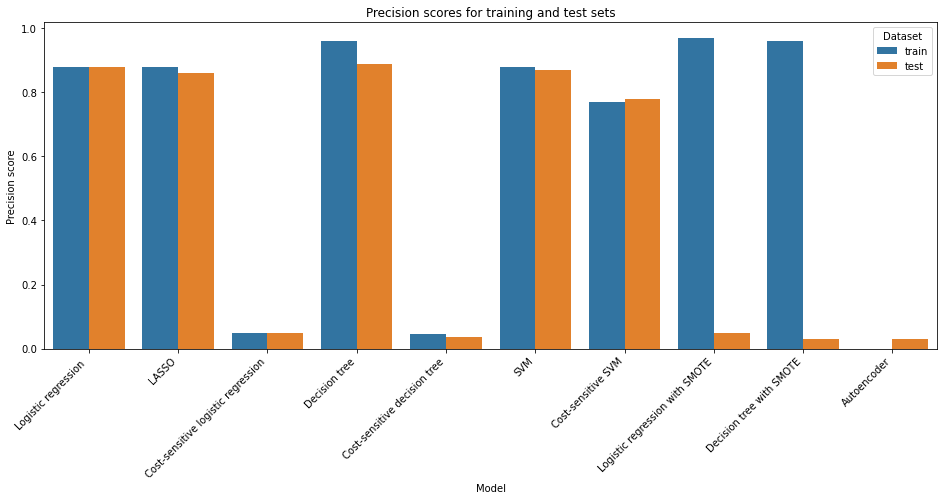

In [121]:
figsize(16, 6)
bar=sns.barplot(result['Model'], y=result['Precision'], hue=result['Dataset'])
bar.set_xticklabels(bar.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Precision scores for training and test sets')
plt.ylabel('Precision score')
plt.show()

Note that for the SMOTE method, the precision scores are really high because we have over-sample the training set. Let's visualize the precision-recall trade-offs on the test set.

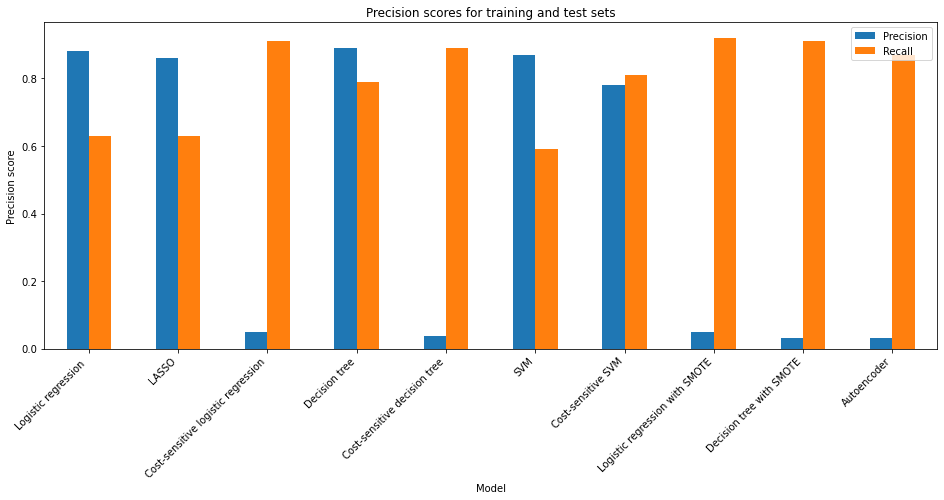

In [129]:
figsize(16, 6)
bar1=test.plot(x='Model', y=['Precision', 'Recall'], kind='bar')
bar1.set_xticklabels(bar.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Precision scores for training and test sets')
plt.ylabel('Precision score')
plt.show()

We see that to keep a very high recall score, we have to trade for a lower precision score.

# Part 6: Conclusions

In this project, we have built several machine learning models to detect fraud transactions. As we demonstrated above, most of our models perform pretty well. We also see that there are trade-offs between precision and recall. 

What is the best model that our clients should adopt? This depends on our clients'priorities. For example, if our client just wants to prevent fraud, we recommend the logistic regression with SMOTE and decision tree with SMOTE. However, if our clients prefer a balance between precision-recall, decision, and cost-sensitive SVM are better models. 

# Part 7: References

Here are some references that we use throughout this project. 

[1] Step-By-Step Framework for Imbalanced Classification Projects

https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/

This article provides an overview of different methods to deal with imbalanced classification problems. 


[2] Credit Card Fraud Detection using Autoencoders in Keras | TensorFlow for Hackers (Part VII)

https://www.curiousily.com/posts/credit-card-fraud-detection-using-autoencoders-in-keras/

This article explains how to implement autoencoder for the same credit card problem that we are solving. We borrow some of the key ideas in this article to build our autoencoder model.